[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/027_pytorch_intro/pytorch_intro.ipynb)

In [ ]:
#Jose Ignacio Duran Daza
#https://github.com/N4CH0000/SIS421

In [2]:
import pandas as pd

# Cargar el archivo CSV de arroz
df = pd.read_csv("rice_classification_data.csv")

# Inspeccionar los primeros registros
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'rice_classification_data.csv'

In [1]:
import tensorflow as tf

# Cargar imágenes y etiquetas desde directorios
data_dir = "ruta/a/las/imagenes"
dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

# Obtener las características (imágenes) y las etiquetas (clases)
X, Y = dataset.map(lambda x, y: (x, y)).unbatch().as_numpy_iterator().next()

NotFoundError: Could not find directory ruta/a/las/imagenes

In [1]:
from sklearn.datasets import fetch_openml

rice = fetch_openml('riceArborio', version=1)
X, Y = rice["data"], rice["target"]

X.shape, Y.shape

((70000, 784), (70000,))

In [ ]:
X = X.to_numpy()
Y = Y.to_numpy()

In [ ]:
print(X.shape)

(70000, 784)


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

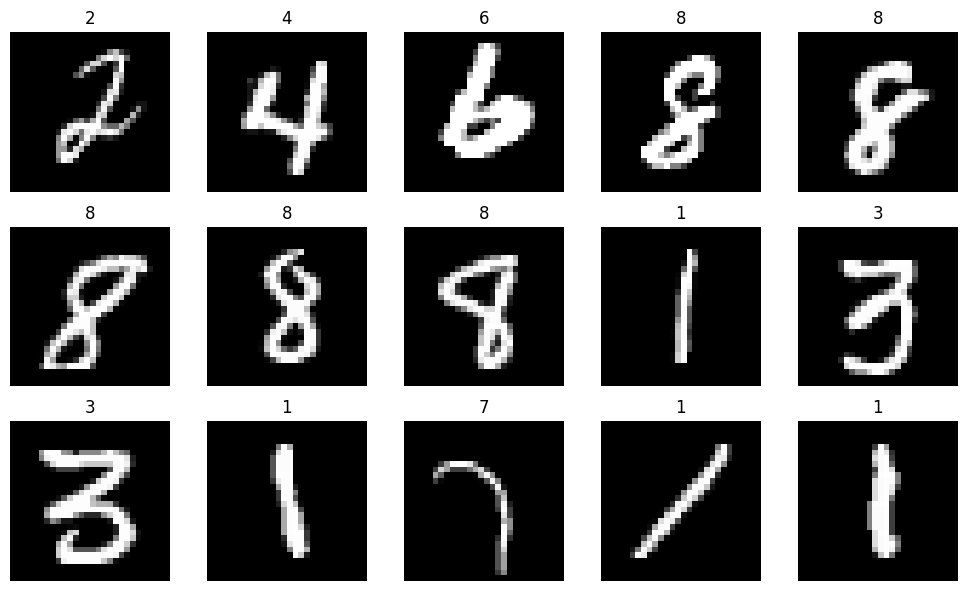

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

In [ ]:
# normalizamos los datos

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(np.int64), Y[60000:].astype(np.int64)

In [ ]:
# función de pérdida y derivada

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [ ]:
D_in, H, D_out = 784, 100, 10

# pesos del MLP (copiamos en gpu)
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H)),
          size = (D_in, H)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H, requires_grad=True, device="cuda", dtype=torch.float)

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H)),
          size = (H, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

epochs = 100
lr = 0.8
log_each = 10
l = []
for e in range(1, epochs+1):

    # forward
    h = X_t.mm(w1) + b1
    h_relu = h.clamp(min=0) # relu
    y_pred = h_relu.mm(w2) + b2

    # loss
    # print(y_pred, Y_t)
    # print(y_pred.shape, Y_t.shape)
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/100 Loss 1.86972
Epoch 20/100 Loss 1.40651
Epoch 30/100 Loss 1.11887
Epoch 40/100 Loss 0.94551
Epoch 50/100 Loss 0.83170
Epoch 60/100 Loss 0.75601
Epoch 70/100 Loss 0.69043
Epoch 80/100 Loss 0.63805
Epoch 90/100 Loss 0.59579
Epoch 100/100 Loss 0.56110


In [ ]:
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2) + b2
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9304

<ipython-input-41-bce804e86d9d>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_pred = evaluate(torch.tensor([img]).float().cuda())[0]


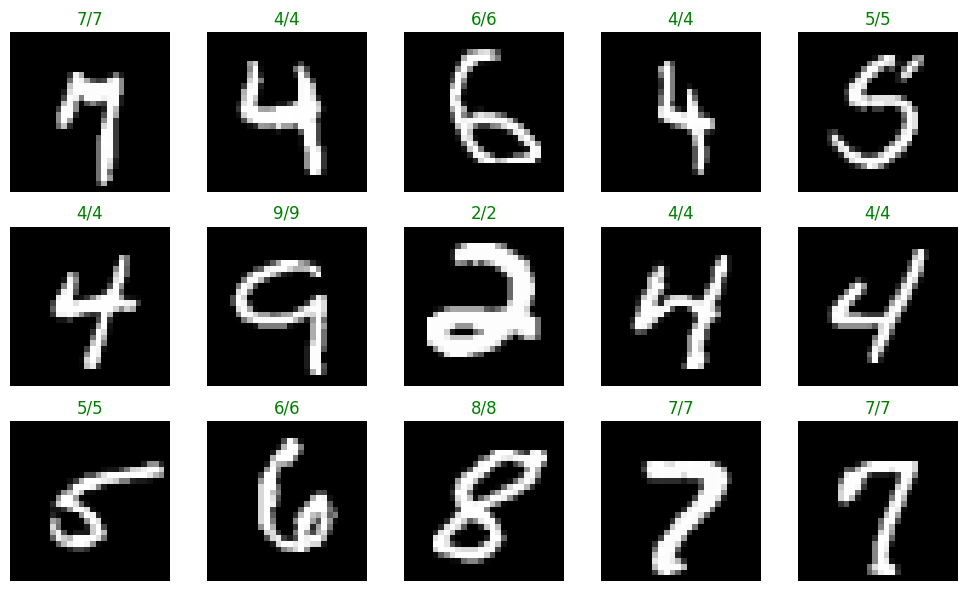

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

Como puedes observar, simplemente definiendo los `tensores` para los pesos y los datos y copiándolos a la GPU podemos definir el `grafo computacional` de manera dinámica aplicando operaciones sobre los tensores (multiplicamos por los pesos y sumamos el *bias*). Una vez tenemos la salida del `MLP` calculamos la función de pérdida y llamando a la función `backward` `Pytorch` se encarga de calcular todas las derivadas de manera automática. Una vez tenemos los gradientes con respecto a los pesos, podemos actualizarlos.

## Resumen

En este post hemos visto una introducción a `Pytorch`, un framework de `redes neuronales` muy utilizado a día de hoy. Hemos visto que `Pytorch` es muy similar a `NumPy` y comparten gran parte de su sintaxis, lo cual es una ventaja si ya sabemos trabajar con `NumPy`. Además, añade `autograd`, la capacidad de construir de manera dinámica un `grafo computacional` de manera que en cualquier momento podemos calcular derivadas con respecto a cualquier tensor de manera automática. Por último, hemos visto como podemos ejecutar todas estas operaciones en una GPU para acelerar el proceso de entrenamiento de nuestros modelos de `Deep Learning`. Este es el núcleo de `Pytorch`, sin embargo esta librería nos ofrece más funcionalidad, de la cual hablaremos más adelante, que nos será muy útil para diseñar, entrenar y poner a trabajar nuestras `redes neuronales`.